In [1]:
import os
from IPython.display import clear_output


notebook_dir = "/home/balabaevvl/courses/project/FITS/src/"
os.chdir(notebook_dir)

GPUs = [
    "GPU-e83bd31b-fcb9-b8de-f617-2d717619413b",
    "GPU-5a9b7750-9f85-49a5-3aae-fe07b1b7661d",
    "GPU-fe2d8dfd-06f2-a5c4-a7fd-4a5f23947005",
    "GPU-0c320096-21ee-4060-8731-826ca2febfab",
    "GPU-baef952c-6609-aace-3b78-e4e07788d5de",
    "GPU-3979d65b-c238-4e9c-0c1c-1aa3f05c56a1",
    "GPU-6c76a2c5-5375-aa06-11d4-0fddfac30e91",
]
os.environ["CUDA_VISIBLE_DEVICES"] = f"{GPUs[2]}"

In [2]:
import torch
from fits.modelling.framework import Train, Evaluate
from fits.dataframes.dataset import DatasetSolar
from fits.dataframes.dataloader import ForecastingDataLoader
from fits.modelling.comparison import (
    CalculateParams,
    ReadMetrics,
    VisualizeForecastSample,
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NSAMPLE = 5

In [ ]:
from fits.dataframes.download import DownloadDatasetSolar

DownloadDatasetSolar()

# VAR

In [ ]:
train_loader, valid_loader, test_loader = ForecastingDataLoader(
    DatasetSolar,
    batch_size=1024,
    n_features=64,
)  # shape=[B, L=96, K=64], horizon=24
normalization_stats = train_loader.dataset.normalization_stats

In [ ]:
from fits.modelling.VAR.model import SeasonalVAR, VARConfig

var = SeasonalVAR(VARConfig(feature_size=64, lag_order=60)).to(device)

print(f"Total params: {CalculateParams(var)}")

In [ ]:
Train(
    var,
    train_loader,
    valid_loader,
    epochs=50,
    valid_epoch_interval=5,
    warmup_epochs=0,
    folder_name="var_solar",
)

In [ ]:
Evaluate(
    var, test_loader, normalization_stats, nsample=NSAMPLE, folder_name="var_solar"
)

In [ ]:
eval_foldername = "var_solar"

ReadMetrics(eval_foldername, nsample=NSAMPLE)
# VisualizeForecastSample(eval_foldername, nsample=NSAMPLE, sample_index=10)

In [ ]:
import gc, torch

del var
gc.collect()
torch.cuda.empty_cache()

# CSDI

In [3]:
train_loader, valid_loader, test_loader = ForecastingDataLoader(
    DatasetSolar,
    batch_size=64,
    n_features=64,
)  # shape=[B, L=96, K=64], horizon=24
normalization_stats = train_loader.dataset.normalization_stats

In [ ]:
from fits.modelling.CSDI.adapter import CSDIAdapter, CSDIConfig, CSDIDiffusionConfig


csdi = CSDIAdapter(
    CSDIConfig(
        target_dim=64,
        num_sample_features=64,
        diffusion=CSDIDiffusionConfig(
            layers=3,
            channels=48,
            nheads=6,
        ),
)).to(device)
print(f"Total params: {CalculateParams(csdi)}")


/home/balabaevvl/courses/venv311/lib/python3.11/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Total params: 220577


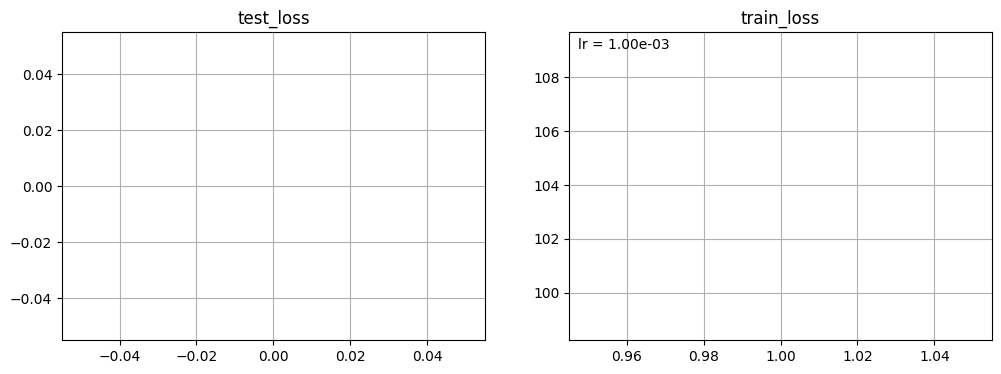

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 779/779 [07:55<00:00,  1.64it/s, avg_epoch_loss=0.0822, epoch=1]


In [ ]:
Train(
    csdi,
    train_loader,
    valid_loader,
    epochs=100,
    valid_epoch_interval=5,
    warmup_epochs=0,
    folder_name="csdi_solar",
)


In [ ]:
model_foldername = "csdi_solar"

state = torch.load(
    f"../data/models/training/{model_foldername}/best_model.pth",
    map_location=device,
)

csdi.load_state_dict(state)
csdi.to(device)

clear_output()

In [ ]:
Evaluate(
    csdi, test_loader, normalization_stats, nsample=NSAMPLE, folder_name="csdi_solar"
)

In [ ]:
eval_foldername = "csdi_solar"

ReadMetrics(eval_foldername, nsample=NSAMPLE)
# VisualizeForecastSample(eval_foldername, nsample=NSAMPLE, sample_index=10)

In [ ]:
import gc, torch

del csdi
gc.collect()
torch.cuda.empty_cache()

# DiffusionTS

In [ ]:
train_loader, valid_loader, test_loader = ForecastingDataLoader(
    DatasetSolar,
    batch_size=1024,
    n_features=64,
)  # shape=[B, L=96, K=64], horizon=24
normalization_stats = train_loader.dataset.normalization_stats

In [ ]:
from fits.modelling.DiffusionTS.adapter import DiffusionTSAdapter, DiffusionTSConfig


diffusionts = DiffusionTSAdapter(
    DiffusionTSConfig(
        seq_len=96,
        feature_size=64,
        timesteps=500,
        sampling_timesteps=200,
    )
).to(device)
print(f"Total params: {CalculateParams(diffusionts)}")

In [ ]:
Train(
    diffusionts,
    train_loader,
    valid_loader,
    epochs=150,
    valid_epoch_interval=5,
    weight_decay=0,
    warmup_epochs=0,
    folder_name="diffusionts_solar",
)

In [ ]:
model_foldername = "diffusionts_solar"

state = torch.load(
    f"../data/models/training/{model_foldername}/best_model.pth",
    map_location=device,
)

diffusionts.load_state_dict(state)
diffusionts.to(device)

clear_output()

In [ ]:
Evaluate(
    diffusionts,
    test_loader,
    normalization_stats,
    nsample=NSAMPLE,
    folder_name="diffusionts_solar",
)

In [ ]:
eval_foldername = "diffusionts_solar"

ReadMetrics(eval_foldername, nsample=NSAMPLE)
# VisualizeForecastSample(eval_foldername, nsample=NSAMPLE, sample_index=10)

# FM-TS

In [ ]:
train_loader, valid_loader, test_loader = ForecastingDataLoader(
    DatasetSolar,
    batch_size=1024,
    n_features=64,
)  # shape=[B, L=96, K=64], horizon=24
normalization_stats = train_loader.dataset.normalization_stats

In [ ]:
from fits.modelling.FMTS.adapter import FMTSAdapter, FMTSConfig


fmts = FMTSAdapter(
    FMTSConfig(
        seq_len=64,
        feature_size=64,
        n_layer_enc=2,
        n_layer_dec=2,
    )
).to(device)
print(f"Total params: {CalculateParams(fmts)}")

In [ ]:
Train(
    fmts,
    train_loader,
    valid_loader,
    epochs=150,
    valid_epoch_interval=5,
    weight_decay=0,
    warmup_epochs=0,
    folder_name="fmts_solar",
)

In [ ]:
Evaluate(
    fmts,
    test_loader,
    normalization_stats,
    nsample=NSAMPLE,
    folder_name="fmts_solar",
)

In [ ]:
eval_foldername = "fmts_solar"

ReadMetrics(eval_foldername, nsample=NSAMPLE)
# VisualizeForecastSample(eval_foldername, nsample=NSAMPLE, sample_index=10)